In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../code")

In [16]:
from scipy.stats import linregress

In [17]:
from manuscript import compute_explained_variance
from manuscript import analyse_one_cohort

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [19]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Load autopsy data
Autopsy data is parsed from raw excel files in [this notebook](autopsy-metastasis-freqs.ipynb). Here we just load the pickled data:

In [20]:
data = pd.read_pickle("../output/data/experimental_metastasis_freqs/all-experimental-metastais-frequency-data.p")

### Load simulations data
Simulations data is first preprocessed in [this notebook](compute-fraction-of-cells-from-simulations.ipynb), which turns a set of trajectories into a primary-organ-to-metastatic-site probability matrix. Here we just load the pickled data.

In [21]:
_model = pd.read_pickle("../output/data/tracers_notrajs/prob_matrix_tracers_notrajs_symmetrized_10000.p")

_dict = {
    'brain': "brain",
    'large_intestine': "large intestine",
    'pancreas': "pancreas",
    'stomach': "stomach",
    'heart': "heart",
    'liver': "liver",
    'small_intestine': "small intestine",
    'prostate': "prostate",
    'gallbladder': "gallbladder",
    'urinary_bladder': "bladder",
    'lung': "lung",
    'kidney': "kidney",
    'adrenal_gland': "adrenal gland"
}

_model.index = [
    _dict[x].replace("stomach", "esophageal and gastric").replace("large intestine", "colorectal")
    for x in _model.index
]
_model.columns = [
    _dict[x]
    for x in _model.columns
]


_model.index.name = "cancer"

_model.columns.name = "metastatic site"

Turn dataframe into long form

In [22]:
# long form
model = _model.reset_index().melt(id_vars=["cancer"])

and save it for later use:

In [23]:
model.to_pickle("../output/data/tracers_notrajs/model-longform.p")

We load a colors dict to be consistent with other figures

In [24]:
colors_dict = pd.read_pickle("../output/data/experimental_metastasis_freqs/study-colors-dict.p")

In [25]:
def do_fig(metadata, figsize=(4, 4)):
    _metadata = metadata.loc[(metadata.fraction_data > 0) & (metadata.fraction_model > 0)].copy()

    _p = _metadata.fraction_data
    _N = _metadata.num_patients_data

    _sigma = np.sqrt(_p * (1 - _p)  / _N)
    measurement_errors = np.abs(_sigma / _p)

    _metadata["fraction_data_lower"] = _metadata.fraction_data / np.exp(measurement_errors)
    _metadata["fraction_data_upper"] = _metadata.fraction_data * np.exp(measurement_errors)


    fig, ax = plt.subplots(1, 1, figsize=figsize, tight_layout=True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("$f_p$")
    ax.set_xlabel("$f_c$")
    x = _metadata.fraction_model
    y = _metadata.fraction_data
    ax.scatter(
        x=x,
        y=y,
        marker="s",
        facecolors=[colors_dict[t] for t in _metadata.Study],
        edgecolors='0.2',
        zorder=10
    )
    for _, record in _metadata.iterrows():
        ax.plot(
            [record.fraction_model, record.fraction_model],
            [record.fraction_data_lower, record.fraction_data_upper],
            c="0.2",
            lw=1
        )
        delta = 1.03
        ax.plot(
            [record.fraction_model / delta, record.fraction_model * delta],
            [record.fraction_data_lower, record.fraction_data_lower],
            c="0.2",
            lw=1
        )
        ax.plot(
            [record.fraction_model / delta, record.fraction_model * delta],
            [record.fraction_data_upper, record.fraction_data_upper],
            c="0.2",
            lw=1
        )
    
    slope, intercept, rvalue, pvalue, _ = linregress(np.log(x), np.log(y))    
    c = 2
    mx, Mx = min(x) / c, max(x) * c
    my, My = min(y) / c, max(y) * c
    x_arr = np.geomspace(mx, Mx)
    f_x_arr = np.exp(intercept + slope * np.log(x_arr))
    ax.plot(x_arr, f_x_arr, c="0.2", lw=1)
    ax.set_xlim(mx, Mx)
    ax.set_ylim(my, My)
    return fig, ax

pancreas
R2_adjusted: 0.6153737321119738
pval: 0.005051528161799066
ratio_flow_total: 0.6153737321119738

esophageal and gastric
R2_adjusted: 0.2514912926754727
pval: 0.018892885107188753
ratio_flow_total: 0.2514912926754727

liver
R2_adjusted: 0.09152581908741399
pval: 0.23402012427887986
ratio_flow_total: 0.09152581908741399

prostate
R2_adjusted: 0.46785516381331527
pval: 0.0026080671729820284
ratio_flow_total: 0.46785516381331527

lung
R2_adjusted: 0.82111333068359
pval: 7.229182833840766e-09
ratio_flow_total: 0.8211133306835902

kidney
R2_adjusted: 0.141578215313233
pval: 0.16765854842212327
ratio_flow_total: 0.141578215313233

colorectal
R2_adjusted: 0.35604163034834396
pval: 0.003032996111385923
ratio_flow_total: 0.35604163034834396



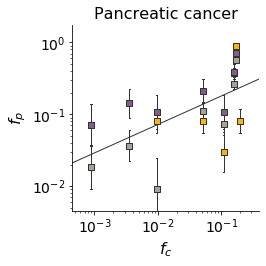

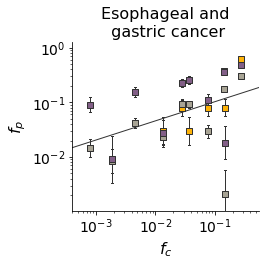

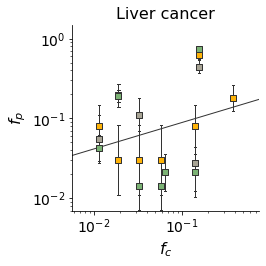

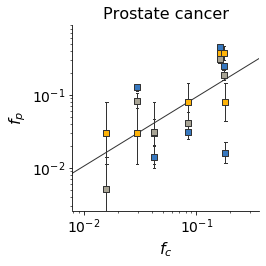

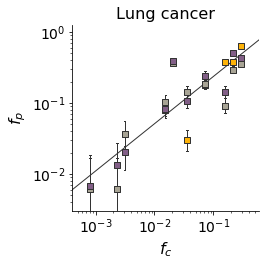

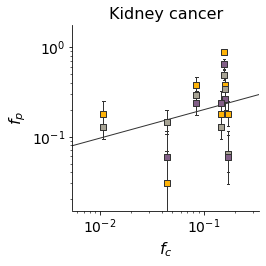

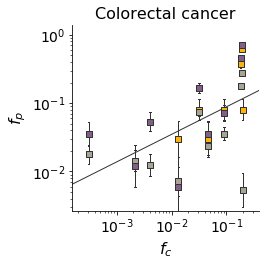

In [26]:
pieces_data = {}
for cancer_type in ["pancreas", "esophageal and gastric", "liver", "prostate", "lung", "kidney", "colorectal"]:
    # high-quality data, at least two studies
    sdata = data.loc[data.cancer == cancer_type]
    result, metadata = analyse_one_cohort(data=sdata, model=model)
    print(cancer_type)
    print("R2_adjusted:", result["R2_adjusted"])
    print("pval:", result["pvalue"])
    print("ratio_flow_total:", result["flow"] / (result["flow"] + result["other"]))
    print()
    fig, ax = do_fig(metadata=metadata.copy(), figsize=(3.8, 3.8))
    ax.set_title((cancer_type[0].upper() + cancer_type[1:] + " cancer").replace("Pancreas", "Pancreatic").replace("and", "and\n"))
    pieces_data[cancer_type] = result
    fig.savefig(f"../figures/model-data-comparison/{cancer_type.replace(' ', '-')}.png", dpi=150)


### Plot variance decomposition

In [56]:
df = pd.DataFrame(pieces_data).T
df = (df[["flow", "other", "noise"]].T / df.meansquare).T
df = df.loc[df.sum(axis=1).sort_values(ascending=False).index]

In [57]:
_data = data

In [58]:
pieces_data_organs = {}
for metastatic_site in ["brain", "heart", "kidney", "liver", "lung", "pancreas"]:
    sdata = _data.loc[_data.metastatic_site == metastatic_site]
    result, metadata = analyse_one_cohort(data=sdata, model=model)
    pieces_data_organs[metastatic_site] = result


In [59]:
df2 = pd.DataFrame(pieces_data_organs).T
df2 = (df2[["flow", "other", "noise"]].T / df2.meansquare).T
df2 = df2.loc[df2.sum(axis=1).sort_values(ascending=False).index]

In [60]:
df.index = [
    x.replace("esophageal", "es.").replace("pancreas", "pancreatic").replace("and", "&")
    for x in df.index
]

Variance decomposition for each primary organ

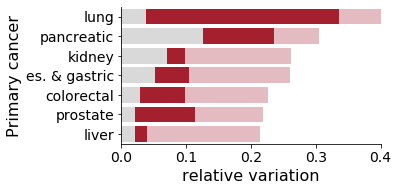

In [61]:
base_color = "#bb0a1e"
fig, ax = plt.subplots(1, 1, figsize=(6, len(df)/2.5), tight_layout=False)
sns.barplot(
    x=df.flow + df.other + df.noise,
    y=df.index,
    color=base_color,
    alpha=0.3,
    ax=ax
)
sns.barplot(
    x=df.flow + df.noise,
    y=df.index,
    color=base_color,
    ax=ax
)

sns.barplot(
    x=df.noise,
    y=df.index,
    color="0.85",
    ax=ax
)
ax.set_ylabel("Primary cancer")
ax.set_xlabel("relative variation")
ax.set_xlim(0, 0.4)
fig.subplots_adjust(bottom=0.2, left=0.3)
fig.savefig("../figures/model-data-comparison/cancer-splitted-variance.png", dpi=150)

Variance decomposition for each metastatic site

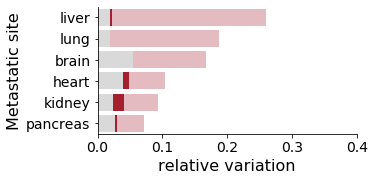

In [62]:

fig, ax = plt.subplots(1, 1, figsize=(6, len(df)/2.7), tight_layout=False)
sns.barplot(
    x=df2.flow + df2.other + df2.noise,
    y=df2.index,
    color=base_color,
    alpha=0.3,
    ax=ax
)
sns.barplot(
    x=df2.flow + df2.noise,
    y=df2.index,
    color=base_color,
    ax=ax
)

sns.barplot(
    x=df2.noise,
    y=df2.index,
    color="0.85",
    ax=ax
)
ax.set_ylabel("Metastatic site")
ax.set_xlabel("relative variation")
ax.set_xlim(0, 0.4)
fig.subplots_adjust(bottom=0.2, left=0.3)
fig.savefig("../figures/model-data-comparison/metastasis-splitted-variance.png", dpi=150)


In [63]:
df.flow / (df.flow + df.other)

lung             0.821113
pancreatic       0.615374
kidney           0.141578
es. & gastric    0.251491
colorectal       0.356042
prostate         0.467855
liver            0.091526
dtype: float64

In [64]:
df2.flow / (df2.flow + df2.other)

liver       0.011946
lung        0.003812
brain       0.003690
heart       0.126366
kidney      0.239975
pancreas    0.059888
dtype: float64